# Tutorial II: Optimization in TensorFlow & NN introduction

<p>
Bern Winter School on Machine Learning, 28.01-01.02 2019<br>
Mykhailo Vladymyrov
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

## download libraries

In [1]:
! wget http://scits-training.unibe.ch/data/tut_files/t1.tgz
! tar -xvzf t1.tgz

--2019-01-29 16:08:49--  http://scits-training.unibe.ch/data/tut_files/t1.tgz
Resolving scits-training.unibe.ch (scits-training.unibe.ch)... 130.92.251.56
Connecting to scits-training.unibe.ch (scits-training.unibe.ch)|130.92.251.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2185 (2.1K) [application/octet-stream]
Saving to: ‘t1.tgz’

t1.tgz              100%[===================>]   2.13K  --.-KB/s    in 0s      

2019-01-29 16:08:49 (264 MB/s) - ‘t1.tgz’ saved [2185/2185]

utils/
utils/gr_disp.py
utils/inception.py
utils/__init__.py
tar: A lone zero block at 16


## 1. Load necessary libraries

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')
from utils import gr_disp

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

MZ - aims: 

-> optimization of 2 parameters

-> then start neural networks 

## 1. Linear fit

Here we will solve optimization problem to perform linear regression. First we will generate training set of 160 data points and test set of 40, laying on a line with a random offset $$y = a_0 x + b_0 + ofs$$, where $ofs$ is a random variable sampled from a normal distribution with standard deviation equal to $s_0$

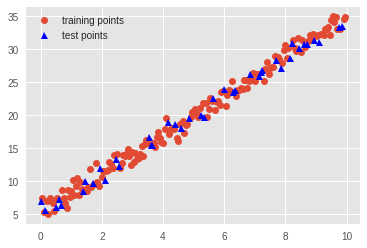

In [5]:
a0 = 3#3
b0 = 5#5
s0 = 1#1

#all samples
x_all = np.arange(0, 10, .05)
n_all = x_all.shape[0]
# MZ: draw some random offsets from normal distribution
ofs_all = s0*np.random.randn(n_all)
# MZ: calculate the corresponding coordinates
y_all = np.asarray([a0*x+b0+o for x, o in zip(x_all, ofs_all)])
    
#randomize order and get 80% for training
idx = np.random.permutation(n_all)
n_train = n_all*80//100

# MZ: -> look only at the training part to find the value of a and b

idx_train = idx[0:n_train]
idx_test = idx[n_train:]

x_train = x_all[idx_train]
y_train = y_all[idx_train]

x_test = x_all[idx_test]
y_test = y_all[idx_test]

plt.plot(x_train, y_train, "o", x_test, y_test, "b^")
plt.legend(('training points', 'test points'),  loc='upper left')

Now we want to find the values of the parametrers a and b.

Find a function that depends on a and b and the minimum value of this function is reached when a and b correspond to the estimate of the true value of the paramters

Basic approach: least square. Loss function as the sum of squared distances between predicted and target points.

We will then define loss function as the mean of squared residuals (distance from line along $y$) for the points.

We will use [stochactic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent): on each iteration use only a fraction (`mini_batch_size`) of all training set. In many cases training set is huge and cannot be fed on each iteration in principle. Also it can sometimes help the optimizer to properly explore the manifold.

0 3.963044 3.5084696 1.7191638
40 0.99670756 3.0661094 4.499829
80 0.8725014 2.9698696 5.0751657
120 0.86355555 2.9625218 5.197219
160 0.866274 2.9480467 5.2219048
200 0.8685492 2.9445207 5.2245235


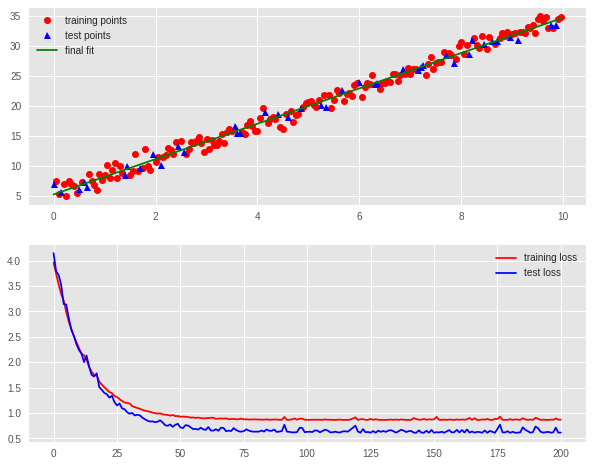

In [6]:
tf.reset_default_graph()

# MZ:
# The optimizer will tune the a and b values
# x and y are the arrays of points

#here we have 2 trainable parameters, a and b
a = tf.get_variable(name='a', dtype=tf.float32, initializer=tf.random_normal(()))
# MZ: specifies the shape, () inside () -> indicates that is a scalar
b = tf.get_variable(name='b', dtype=tf.float32, initializer=tf.random_normal(()))
x = tf.placeholder(name='x', dtype=tf.float32, shape=(None))
y = tf.placeholder(name='y', dtype=tf.float32, shape=(None))

# define the loss -> least square
# MZ: residuals = distances along the y axis
residual = y - tf.multiply(x,a) - b 
residual2 = tf.square(residual)
loss = tf.reduce_mean(residual2)

# gradient descent to optimize the loss
# loss = mean squared distance 
optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss) #0.005
mini_batch_size = 10 # 10

# MZ - new here: perform schocastic gradient descent
# instead of taking all points at once, randomly sample from the points
# optimize on a part of the points, then take another part of the points, etc.
# if too much data -> not possible to perform optimization on single data point,
# because of memory issue, not achievable to iterate over all data points
# n_train = total number of points that we have
# mini_match_size of 10 -> take the first ten data, then the ten followers, etc.
        
l_sv_train = []
l_sv_test = []
with tf.Session() as sess:
    #initialize all the variables 
    sess.run(tf.global_variables_initializer())
    
    #iterate training for 201 epoch
    # 200 times through all the minibatches
    for epoch in range (201):
        #shuffle the data and perform stochastic gradient descent by runing over all minibatches
        idx = np.random.permutation(n_train)
        for mb in range(n_train//mini_batch_size):
            sub_idx = idx[mini_batch_size*mb:mini_batch_size*(mb+1)]
            # MZ: optimization step using one of this mini_batch
            sess.run(optimizer, feed_dict={x:x_train[sub_idx], y:y_train[sub_idx]})
            
        #evaluate and save test and training loss, to be plotted in the end
        # MZ: evaluate value of loss function on all the points from test and train
        l_val_test = sess.run(loss, feed_dict={x:x_test, y:y_test})
        l_val_train = sess.run(loss, feed_dict={x:x_train, y:y_train})
        if epoch%40==0:
            l_val, a_val, b_val = sess.run([loss, a, b], feed_dict={x:x_train, y:y_train})
            print(epoch, l_val, a_val, b_val)
            
        l_sv_train.append(l_val_train)
        l_sv_test.append(l_val_test)
        
end_fit_x = [x_all[0], x_all[-1]]
end_fit_y = [a_val*x+b_val for x in end_fit_x]
true_fn_y = [a0*x+b0 for x in end_fit_x]
fig, axs = plt.subplots(2, 1, figsize=(10,8))
axs[0].plot(x_train, y_train, 'ro', x_test, y_test, 'b^', end_fit_x, end_fit_y, 'g')
axs[0].legend(('training points', 'test points', 'final fit'),  loc='upper left')
ep_arr = np.arange(len(l_sv_train))
axs[1].plot(ep_arr, l_sv_train, 'r', ep_arr, l_sv_test, 'b')
axs[1].legend(('training loss', 'test loss'),  loc='upper right')

# MZ:
# print the following fields:
# epoch - mean squared distance (loss) - value of a - value of b

# best l_val: ~0.87

size of the split of the data -> depends on the data you have

if too small -> risk of overfitting

image classification: 100'000 per class -> split 95-5-5% of the data (5% is not too small)

## 2. Excercise 1

Play with the true function parameters ```a0, b0, s0``` and the ``mini_batch_size`` value, check how it affects the convergence.

1. How change of `s0` affects convergance?
2. When one should stop training to prevent overfitting?

0 102.548935 3.9875488 1.264828
40 101.35293 2.9832647 4.2594953
80 101.25609 3.5487578 5.050209
120 97.42528 3.1539376 5.087875
160 100.8408 3.510467 5.1788073
200 99.53494 2.9361448 5.115214


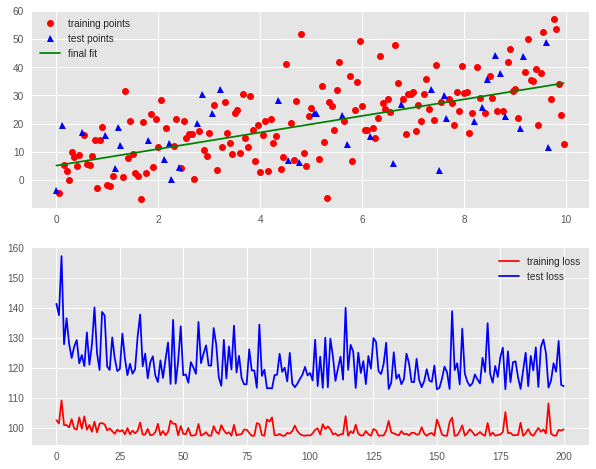

In [11]:
# 1) CHANGE s0

# s0 -> amplitude variation for the random offset 

a0 = 3#3
b0 = 5#5
s0 = 5#1 -> mean loss 23.81 # training loss and test loss curves separated (test over training)
s0 = 0#1 -> mean loss 1.2e-6 # overlap training loss and test loss curves
s0 = 10#1 -> mean loss 99.84
# => increase of s0 slows the convergence


x_all = np.arange(0, 10, .05)
n_all = x_all.shape[0]
ofs_all = s0*np.random.randn(n_all)
y_all = np.asarray([a0*x+b0+o for x, o in zip(x_all, ofs_all)])
    
idx = np.random.permutation(n_all)
n_train = n_all*80//100

idx_train = idx[0:n_train]
idx_test = idx[n_train:]

x_train = x_all[idx_train]
y_train = y_all[idx_train]

x_test = x_all[idx_test]
y_test = y_all[idx_test]

tf.reset_default_graph()

a = tf.get_variable(name='a', dtype=tf.float32, initializer=tf.random_normal(()))
b = tf.get_variable(name='b', dtype=tf.float32, initializer=tf.random_normal(()))
x = tf.placeholder(name='x', dtype=tf.float32, shape=(None))
y = tf.placeholder(name='y', dtype=tf.float32, shape=(None))

residual = y - tf.multiply(x,a) - b 
residual2 = tf.square(residual)
loss = tf.reduce_mean(residual2)

optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss) #0.005
mini_batch_size = 10 # 10

l_sv_train = []
l_sv_test = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range (201):
        idx = np.random.permutation(n_train)
        for mb in range(n_train//mini_batch_size):
            sub_idx = idx[mini_batch_size*mb:mini_batch_size*(mb+1)]
            sess.run(optimizer, feed_dict={x:x_train[sub_idx], y:y_train[sub_idx]})
            
        l_val_test = sess.run(loss, feed_dict={x:x_test, y:y_test})
        l_val_train = sess.run(loss, feed_dict={x:x_train, y:y_train})
        if epoch%40==0:
            l_val, a_val, b_val = sess.run([loss, a, b], feed_dict={x:x_train, y:y_train})
            print(epoch, l_val, a_val, b_val)
            
        l_sv_train.append(l_val_train)
        l_sv_test.append(l_val_test)
        
end_fit_x = [x_all[0], x_all[-1]]
end_fit_y = [a_val*x+b_val for x in end_fit_x]
true_fn_y = [a0*x+b0 for x in end_fit_x]
fig, axs = plt.subplots(2, 1, figsize=(10,8))
axs[0].plot(x_train, y_train, 'ro', x_test, y_test, 'b^', end_fit_x, end_fit_y, 'g')
axs[0].legend(('training points', 'test points', 'final fit'),  loc='upper left')
ep_arr = np.arange(len(l_sv_train))
axs[1].plot(ep_arr, l_sv_train, 'r', ep_arr, l_sv_test, 'b')
axs[1].legend(('training loss', 'test loss'),  loc='upper right')

# s0 = 1 best l_val: 0.86
# s0 = 5 best l_val: 23.81

In [0]:
overfit

big fluctuation around true position (high s0) -> needs

bigger mini_batch -> less iteration on each epoch

s0=40

epoch=600 

training loss continues to decrease, but after 50 epochs, test loss start again to increase; test data different to the train data; we are getting of from the test data (indicates that we are getting off from true distribution)

overfitting: loss of test data decrease than increase again

## 3. A bit of things

The training as we just saw is done iteratively, by adjusting the model parameters.

We perform optimization several times for all traininng dataset. Going through all this dataset is refered to as 'epoch'.

When we do training its usually done in two loops. In outer loop we iterate over all epochs. For each epoch we usually split the dataset into small chuncks, 'mini-batches', and optimization it performed for all of those.

It is important that data doesn't go to the training pipeline in same order. So the overall scheme looks like this (pseudocode):


```
x,y = get_training_data()
for epoch in range(number_epochs):
   x_shfl,y_shfl = shuffle(x,y)
   
   for mb_idx in range(number_minibatches_in_batch):
       x_mb,y_mb = get_minibatch(x_shfl,y_shfl, mb_idx)
       
       optimize_on(data=x_mb, labels=y_mb)
```

Shuffling can be easily done using permuted indexes.

In [12]:
#some array
arr = np.array([110,111,112,113,114,115,116])

#we can get sub-array for a set of indexes, eg:
idx_1_3 = [1,3]
sub_arr_1_3 = arr[idx_1_3]
print (arr,'[',idx_1_3,']','->', sub_arr_1_3)

[110 111 112 113 114 115 116] [ [1, 3] ] -> [111 113]


In [13]:
# MZ: number from 0 to 6 in random order
ordered_idx = np.arange(7)
permuteded_idx = np.random.permutation(7)
print(ordered_idx)
print(permuteded_idx)

permuted_arr = arr[permuteded_idx]
print (arr,'[',permuteded_idx,']','->', permuted_arr)

[0 1 2 3 4 5 6]
[3 5 6 1 4 2 0]
[110 111 112 113 114 115 116] [ [3 5 6 1 4 2 0] ] -> [113 115 116 111 114 112 110]


Some additional np things in this tutorial:

In [14]:
#index of element with highest value
np.argmax(permuted_arr)

# MZ: gives the index of the maximum element (not the actual maximal value)

2

In [16]:
arr2d = np.array([[0,1],[2,3]])
print(arr2d)

[[0 1]
 [2 3]]


In [17]:
#flatten
# MZ: concatenates rows to 1D array
arr_flat = arr2d.flatten()
#reshape
arr_4 = arr2d.reshape((4))
arr_4_1 = arr2d.reshape((4,1))

print (arr_flat)
print (arr_4)
print (arr_4_1)

[0 1 2 3]
[0 1 2 3]
[[0]
 [1]
 [2]
 [3]]


## 4. Bulding blocks of a neural network

MZ

linear combination of the input + some biases -> new values z

calculate non linear transformation of these values

1 neuron that does this transformation. takes bunch of input, weigths with some coefficients and performs linear transformation

many neurons, take the same input, have same transformation function, but have different weights and biases -> will give 2 different outputs
-> 1 layer of neural network

optimization; define another function for the loss function

optimizer that optimizes the parameters by minimizing loss function

cf. the definition calculates the formula

Neural network consists of layers of neurons. Each neuron perfroms 2 operations.
1. Calculate the linear transformation of the input vector $\bar x$: 
$$z = \bar W \cdot \bar x + b = \sum {W_i x_i} + b$$ where $\bar W$ is vector of weights and $b$ - bias.
2. Perform the nonlinear transformation of the result using activation function $f$ $$y = f(z)$$ Here we will use rectified linear unit activation.

In a fully connected neural network each layer is a set of N neurons, performing different transformations of all the same layer's inputs $\bar x = [x_i]$ producing output vector $\bar y = [y_j]_{i=1..N}$: $$y_j = f(\bar W_j \cdot \bar x + b_j)$$

Since output of each layer forms input of next layer, one can write for layer $l$: $$x^l_j = f(\bar W^l_j \cdot \bar x^{l-1} + b^l_j)$$ where $\bar x^0$ is network's input vactor.

To simplify building the network, we'll define a helper function, creating neuron layer with given number of outputs:

In [0]:
# MZ: implements the formula

# activation = non linear function to calculate the output

def fully_connected_layer(x, n_output, name=None, activation=None):
    """Fully connected layer.

    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        TF Scope to apply
    activation : None, optional
        Non-linear activation function

    Returns
    -------
    h, W : tf.Tensor, tf.Tensor
        Output of the fully connected layer and the weight matrix
    """
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=None)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=None):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W

In the case of classification, in the the last layer we use *softmax* transformation as non-linear transformation: $$y_i = \sigma(\bar z)_i = \frac{ e^{z_i}}{\sum_j e^{z_j}}$$

This will correspond to the one-hot labels that we use.
Finally we will use the cross entropy as the loss function: $$H(Y_{pred}, Y_{true}) = - \sum_i Y_{true, i} \log(Y_{pred, i})$$

## 5. Bulding a neural network

In [0]:
n_input = 10
n_output = 2

In [0]:
g = tf.Graph()
with g.as_default():
    X = tf.placeholder(name='X', dtype=tf.float32, shape=[None, n_input])
    Y = tf.placeholder(name='Y', dtype=tf.float32, shape=[None, n_output])
    
    #layer 1: 10 inputs -> 4, softmax activation
    
    # MZ: output of 1st layer = input of 2nd layer
    
    L1, W1 = fully_connected_layer(X , 4, 'L1', activation=tf.sigmoid)
    L2, W2 = fully_connected_layer(L1 , 2, 'L2', activation=None)
    Y_onehot = tf.nn.softmax(L2, name='Logits')
    
    #prediction: onehot->integer
    Y_pred = tf.argmax(Y_onehot, axis=1, name='YPred')

In [22]:
print(X)
print(Y)
print(Y_pred)

Tensor("X:0", shape=(?, 10), dtype=float32)
Tensor("Y:0", shape=(?, 2), dtype=float32)
Tensor("YPred:0", shape=(?,), dtype=int64)


In [23]:
gr_disp.show(g.as_graph_def())

 MZ: 
 
 2 layers, L1 and L2, input x (10 columns and unkwon number of rows)

L1: take the input values, multiplies by the weights, add some biases, calculate sigmoid activation and pass the output

L2: take this output and doe xactly the same task